2023-10-23 12:09:15.070730: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 12:09:15.071855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 12:09:15.095589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 12:09:15.096022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 12:09:15.542643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/3
Step 1500/1500
Epoch 2/3
Step 1500/1500
Epoch 3/3
Step 1500/1500
Maximum number of predictions available: 209510
Number of predictions to be performed: 1000
prediction number: 0
6/6 [==============================] - 0s 3ms/step
prediction number: 1
6/6 [==============================] - 0s 3ms/step
prediction number: 2
6/6 [==============================] - 0s 2ms/step
prediction number: 3
6/6 [==============================] - 0s 2ms/step
prediction number: 4
6/6 [==============================] - 0s 2ms/step
prediction number: 5
6/6 [==============================] - 0s 2ms/step
prediction number: 6
6/6 [==============================] - 0s 2ms/step
prediction number: 7
6/6 [==============================] - 0s 2ms/step
prediction number: 8
6/6 [==============================] - 0s 2ms/step
prediction number: 9
6/6 [==============================] - 0s 2ms/step
prediction number: 10
6/6 [==============================] - 0s 2ms/step
prediction number: 11
6/6 [=============

/home/mreza/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


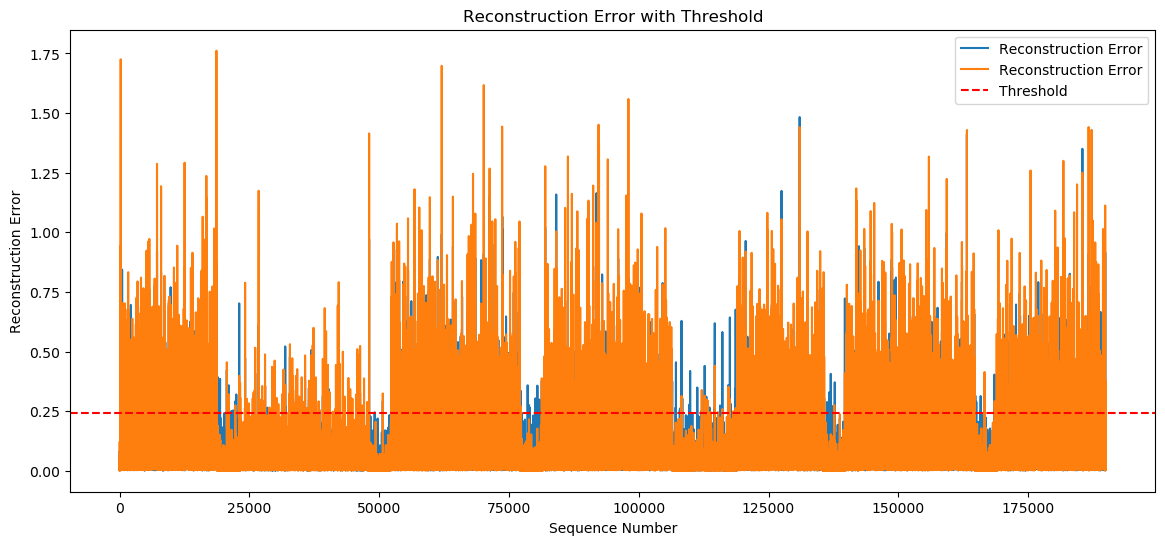

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import os
import struct

def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)


class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length

        if self.file_extension == '.dat':
            samples = []
            while True:
                binary_data = self.binary_file.read(8)
                if not binary_data:
                    break 
                decoded_data = struct.unpack('ff', binary_data)
                if decoded_data[0] == 0 and decoded_data[1] == 0:
                    decoded_line = f"0j\n"
                else:
                    if decoded_data[1] >= 0:
                        decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n"
                    else:
                        decoded_line = f"{decoded_data[0]}{decoded_data[1]}j\n"
                samples.append(decoded_line)

                if self.max_samples and self.total_samples_processed >= self.max_samples:
                    raise StopIteration
                self.total_samples_processed += 1
                #print('samples:', samples)
                if len(samples) == chunksize:
                    X_chunk = self.process_data(samples)
                    #print('X_chunk:', X_chunk)
                    if self.for_training:
                        return X_chunk, X_chunk
                    else:
                        return X_chunk
                    samples = []

        
        else:
            raise StopIteration


#in RNN: we should determine the number of consecutive samples grouped together as a single input 
#sequence for the RNN, so the model will take the first N samples as input 
#and try to reconstruct them.

sequence_length = 10


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 2), return_sequences=True))
model.add(LSTM(25, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))

model.compile(optimizer='adam', loss='mse')

# first I need to train pure data batch by batch

batch_size = 20
num_pure_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat')
#print('num_pure_samples:', num_pure_samples)

max_train_samples = None  # I limit the train or can put None for whole data
train_steps = (min(num_pure_samples, max_train_samples) if 
               max_train_samples else num_pure_samples) // (batch_size * sequence_length)


train_gen_instance = DataGenerator('/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat', 
                                   batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)

# Modify training loop
num_epochs = 3  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        model.train_on_batch(X_chunk, Y_chunk)
        print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
    print()

combined_gen_instance = DataGenerator('/home/mreza/5G accelerator/models/5G_DL_IQ_with_periodic_jamming_0928_02.dat', 
                                      batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)


num_samples = count_lines('/home/mreza/5G accelerator/models/5G_DL_IQ_with_periodic_jamming_0928_02.dat')
max_predictions = num_samples // (batch_size * sequence_length)

num_predictions = 1000  # or any other large number
num_predictions = min(num_predictions, max_predictions)

print(f"Maximum number of predictions available: {max_predictions}")
print(f"Number of predictions to be performed: {num_predictions}")

reconstruction_errors = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        X_chunk_test = next(combined_gen_instance)
        X_chunk_pred = model.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)
except StopIteration:
    print("All samples processed.")
    
    
reconstruction_error = np.array(reconstruction_errors)
print("Reconstruction error calculated.")

# set threshold
threshold = np.percentile(reconstruction_error, 95)
print('threshold:', threshold)

jamming_detected = reconstruction_error > threshold
print('jamming_detected:', jamming_detected)

train_gen_instance.close()
combined_gen_instance.close()




#Table to get insight
flattened_jamming_detected = jamming_detected.flatten()

real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count

# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count

# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})

print(df)

num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()




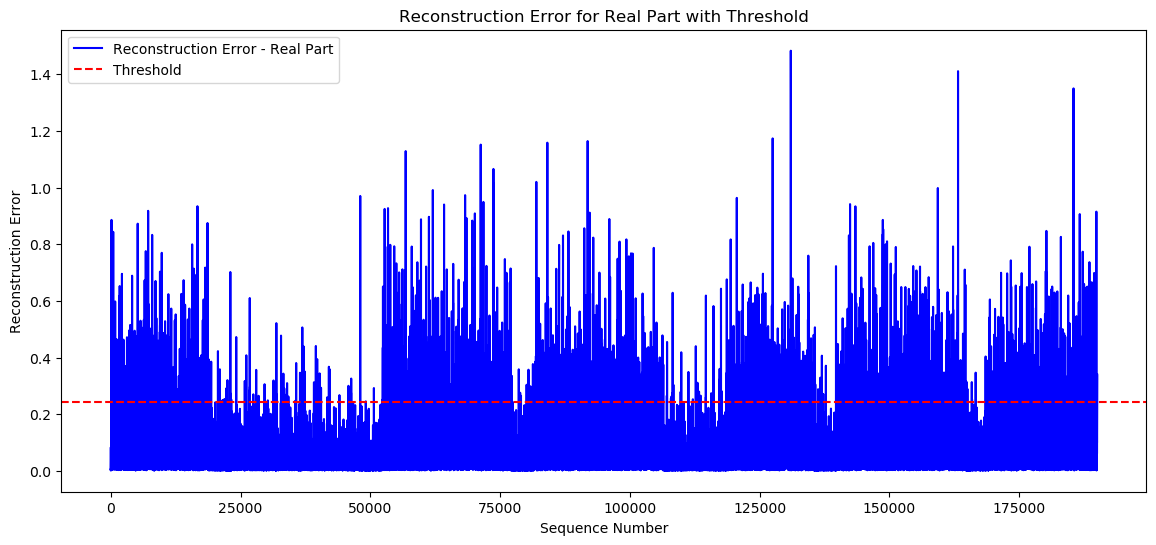

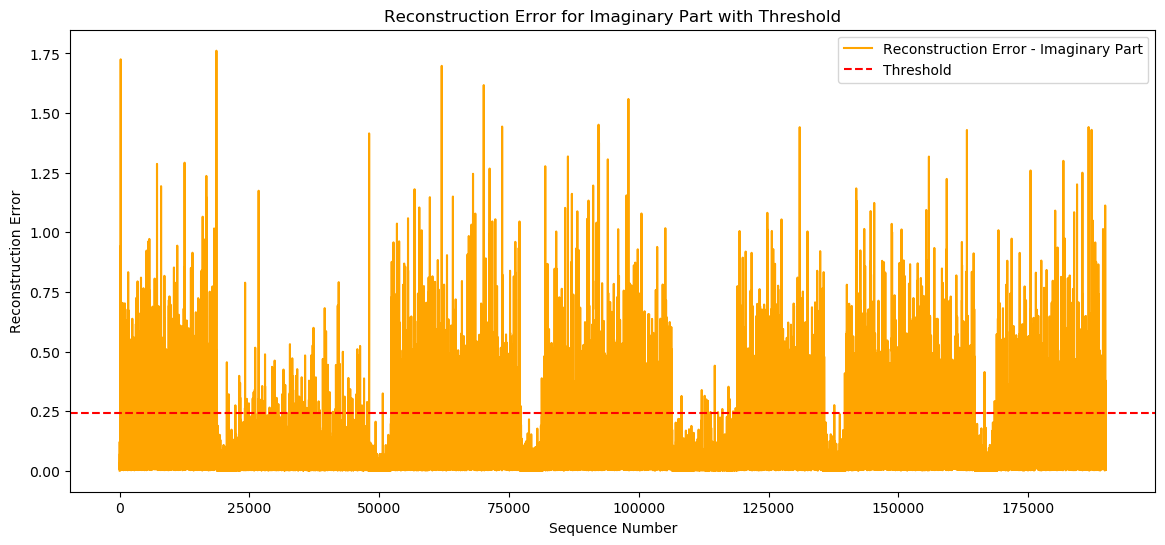

In [2]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_real, label='Reconstruction Error - Real Part', color='blue')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Real Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# Plot for Imaginary Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_imag, label='Reconstruction Error - Imaginary Part', color='orange')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Imaginary Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


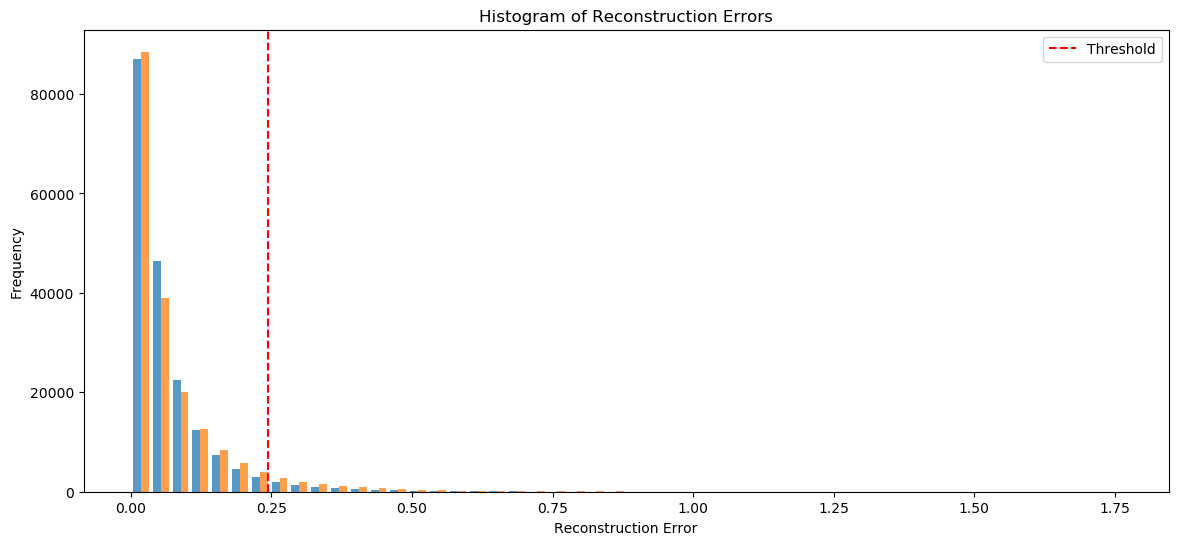

In [3]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


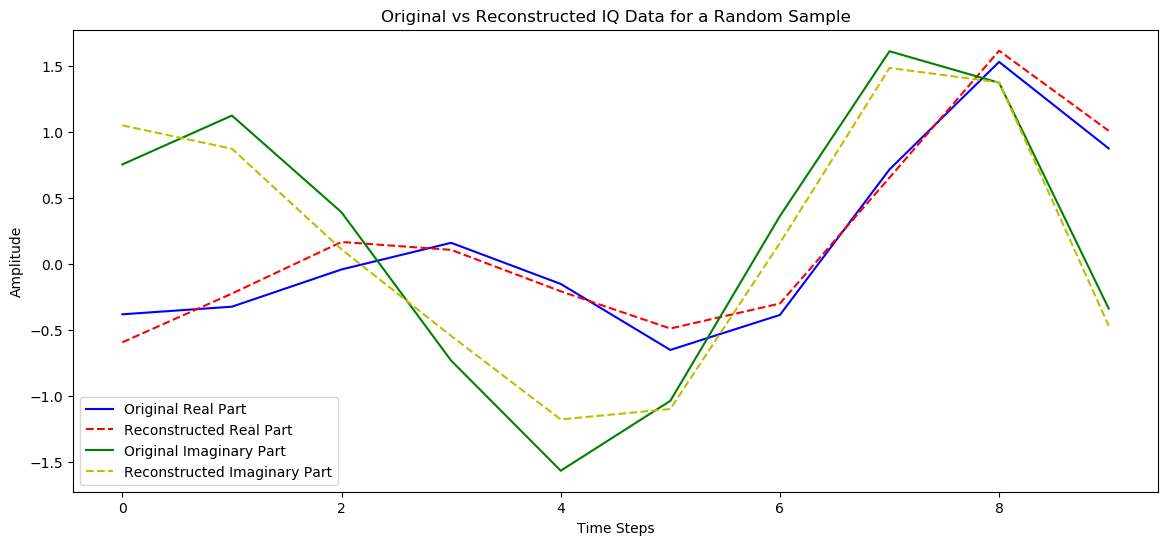

In [4]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data for a Random Sample')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


Shape of avg_real: (190,)
Shape of avg_imag: (190,)
Shape of last_errors: 190


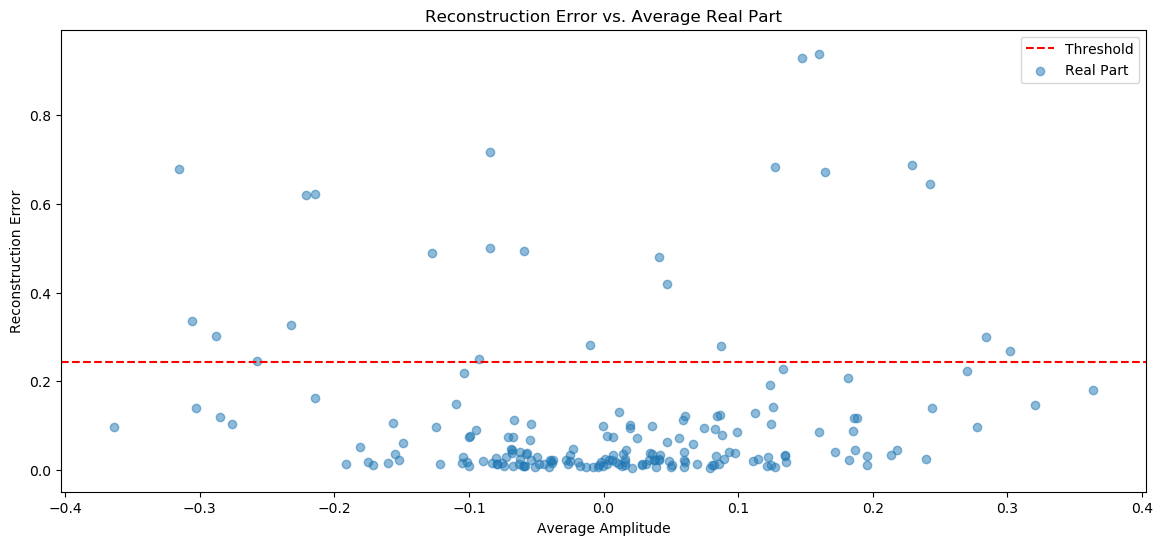

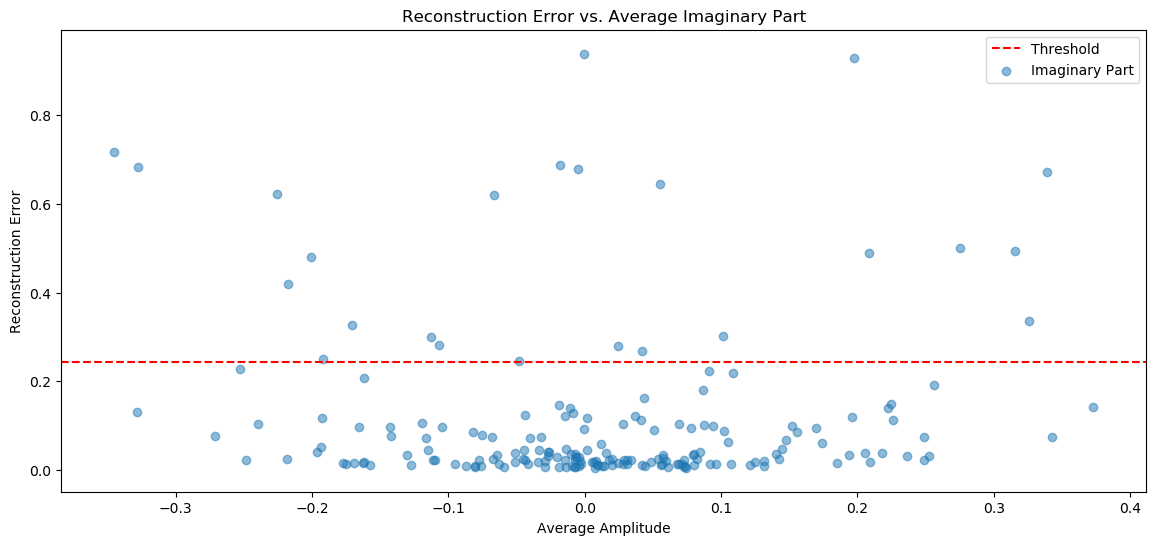

In [5]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()




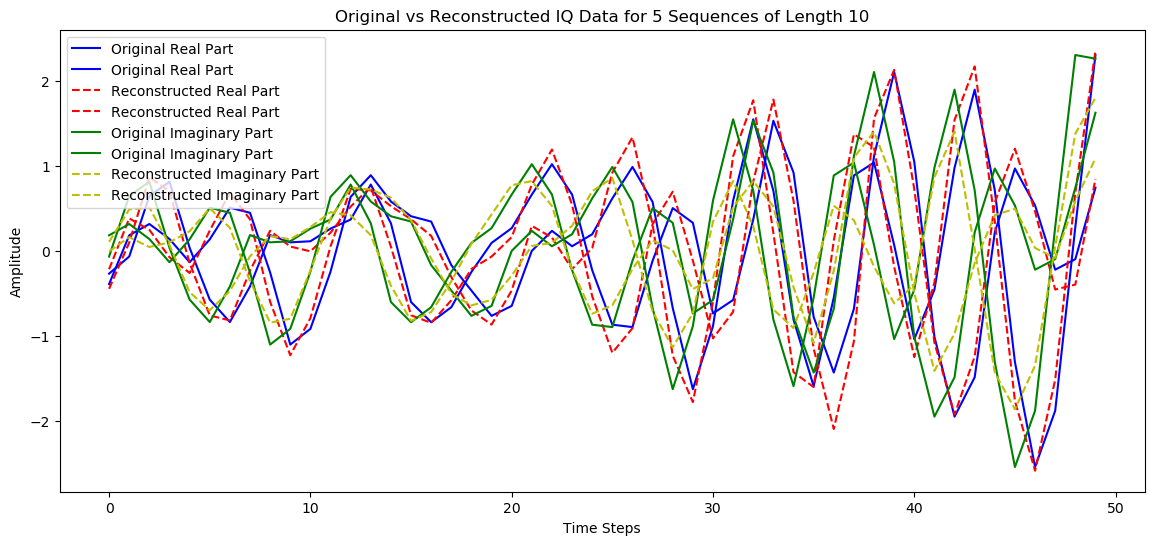

In [6]:
# Define the number of sequences to plot together
n = 5  # change this to desired number of sequences
sample_length = sequence_length * n

# Select a random sample for plotting
sample_index = np.random.choice(len(X_chunk_test) - sample_length + 1)

# Extract the original and reconstructed samples
original_sample = X_chunk_test[sample_index:sample_index + sample_length]
reconstructed_sample = X_chunk_pred[sample_index:sample_index + sample_length]

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


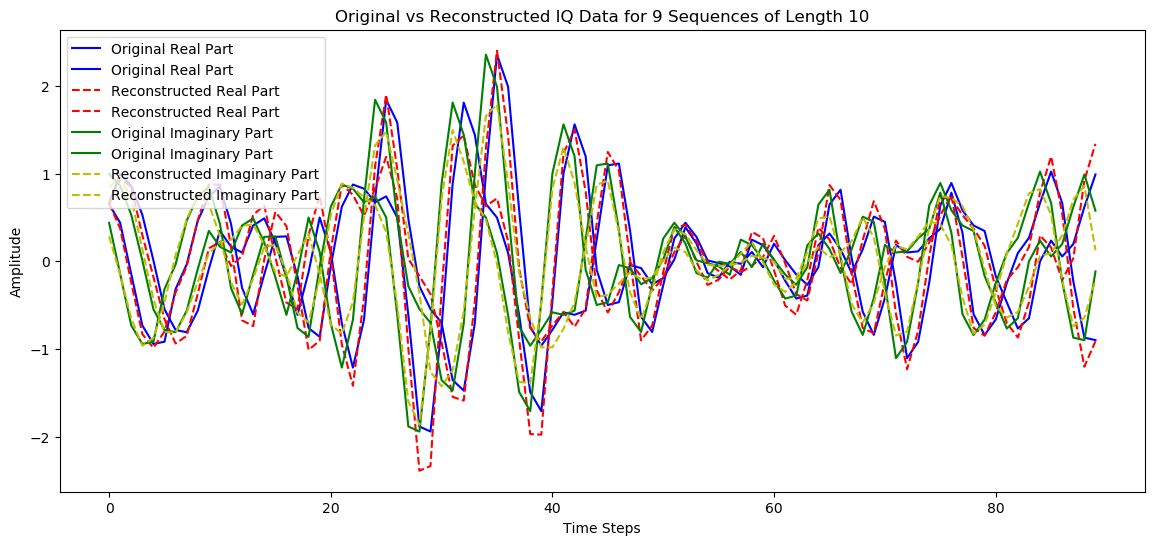

In [7]:
# Define the number of sequences to plot together
n = 9  # You can change this to the desired number of sequences
sample_length = sequence_length * n

# Select a random sample for plotting
sample_index = np.random.choice(len(X_chunk_test) - sample_length + 1)

# Extract the original and reconstructed samples
original_sample = X_chunk_test[sample_index:sample_index + sample_length]
reconstructed_sample = X_chunk_pred[sample_index:sample_index + sample_length]

# Plot the concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
